In [77]:
import os
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch
from torch import nn as nn

from PIL import Image

import numpy as np

import datetime

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Cuda available, training on GPU")
else:
    print("Cuda unavailable, training on CPU")

Cuda available, training on GPU


In [69]:
data_dir = '/media/bartek/889CBCD79CBCC14C/msc-newdataset/'
data_ratio = (.75, .2, .05)         # train, validate, test

In [70]:
# --------------------------------------------------- #
#                   Print the classes
# --------------------------------------------------- #

class_names = []

for class_name in os.listdir(data_dir):
    class_names.append(class_name)

print(f"Classes being trained: {class_names}")

Classes being trained: ['bottle', 'matches', 'mug', 'parfum', 'pen']


In [76]:
# --------------------------------------------------- #
#           Transform the data before
#        putting into the Neural Network
# --------------------------------------------------- #

transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),      # 3 channels - RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_validate = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [72]:
# --------------------------------------------------- #
#              Creating datasets
# --------------------------------------------------- #

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
print(f"Full dataset: {len(full_dataset)} images")

# Data partitioning
all_indices = list(range(len(full_dataset)))

train_size = data_ratio[0]
val_size = data_ratio[1] / (data_ratio[1] + data_ratio[2])  # proporcja wśród reszty

train_idx, rest_idx = train_test_split(
    all_indices, train_size=train_size, shuffle=True, random_state=42
)

val_idx, test_idx = train_test_split(
    rest_idx, train_size=val_size, shuffle=False, random_state=42   # shuffle not required
)

# Creating subsets
train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)
test_data = Subset(full_dataset, test_idx)

# Info
print(f"Train_data length: {len(train_data)}")
print(f"Val_data length:   {len(val_data)}")
print(f"Test_data length:  {len(test_data)}")

Full dataset: 979 images
Train_data length: 734
Val_data length:   196
Test_data length:  49


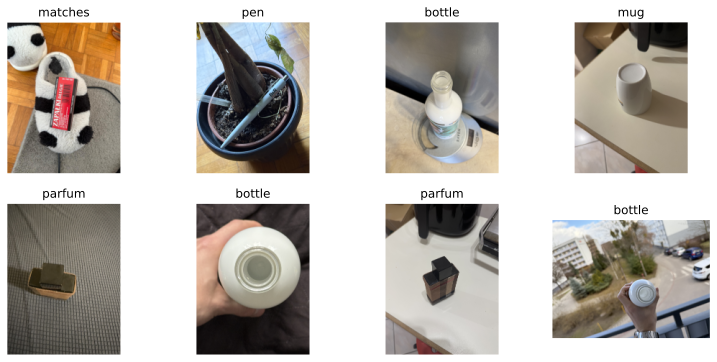

In [75]:
# --------------------------------------------------- #
#              Displaying images
# --------------------------------------------------- #

# images to show
rows = 2
columns = 4

n_images = rows * columns

# Listy na obrazki i etykiety
image_paths = []
image_labels = []


for i in range(n_images):
    # choosing random class
    class_index = np.random.randint(len(class_names))
    selected_class = class_names[class_index]

    # path to class
    class_path = os.path.join(data_dir, selected_class)

    # all images in the class
    all_images = os.listdir(class_path)

    # choosing random item
    selected_image = all_images[np.random.randint(len(all_images))]

    # saving path and image
    full_path = os.path.join(class_path, selected_image)
    image_paths.append(full_path)
    image_labels.append(selected_class)


# plotting the images
fig, axs = plt.subplots(2, 4, figsize=(13, 6))

for i in range(rows*columns):
    img = Image.open(image_paths[i]).convert("RGB")
    axs.flat[i].imshow(img)
    axs.flat[i].set_title(image_labels[i])
    axs.flat[i].axis('off')

# ['bottle', 'matches', 'mug', 'parfum', 'pen']

plt.savefig(f"Resources/1-example-images-{str(datetime.datetime.now())[:19].replace(' ', '-')}.png")
plt.show()

In [74]:
# --------------------------------------------------- #
#              Initializing models
# --------------------------------------------------- #

from torchvision.models import (
    vgg16, VGG16_Weights,
    mobilenet_v2, MobileNet_V2_Weights,
    resnet18, ResNet18_Weights
)

model_vgg16         = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
model_mobilenet_v2  = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2).to(device)
model_resnet18      = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

In [81]:
# --------------------------------------------------- #
#        Adjusting model outputs to fit 5 classes
# --------------------------------------------------- #

n_outputs = len(class_names)
n_inputs = model_vgg16.fc.in_features

model_vgg16.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(n_inputs, n_outputs)
)

print(model_vgg16.fc.in_features)

'''print(model_mobilenet_v2.fc.in_features)
print(model_resnet18.fc.in_features)'''

AttributeError: 'VGG' object has no attribute 'fc'